# Deconvolution examples 


Demonstrate deconvolution based on David Hoffman's code.
All of the necessary functions have been put into a single file.


### `numpy` versus `cupy` 

The deconvolution code can be used on GPU with `cupy`, requiring no further changes to the code,
thanks to [`NEP-018`](https://numpy.org/neps/nep-0018-array-function-protocol.html). I became
aware of this through [this dask blog post](https://github.com/dask/dask-blog/pull/77

Volker Hilsenstein

In [1]:
from decon_onefile import richardson_lucy, _prep, _richardson_lucy
from pathlib import Path
import tifffile
import napari
from napari.utils import nbscreenshot
import numpy as np

%gui qt


## Download/read sample data and PSF

We use the Drosophila example set from the [DeconvolutionLab2 paper by Sage et al.](http://bigwww.epfl.ch/deconvolution/deconvolutionlab2/) from EPFL.

In [2]:
p_vol = Path("./Drosophila/Drosophila.tif")
p_psf = Path("./Drosophila/PSF BWz=100nm.tif")

if not p_vol.exists() or not p_psf.exists():
    import requests, zipfile, io

    url_droso = (
        "http://bigwww.epfl.ch/deconvolution/deconvolutionlab2/material/drosophila-crop.zip"
    )
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36"
    }
    print(f"Downloading example dataset {url_droso}")
    r = requests.get(url_droso, stream=True, headers=headers)
    print("Extracting example dataset ...")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print("... done.")

try:
    print("Reading sample volume and PSF")
    vol_droso = tifffile.imread(p_vol)
    psf_droso = tifffile.imread(p_psf)
except:
    print("Cannot open sample file. Check whether the sample data was downloaded correctly.")

Extracting example dataset ...
... done.
Reading sample volume and PSF


In [3]:
v = napari.Viewer()
v.add_image(vol_droso, name="raw drosophila volume")

<Image layer 'raw drosophila volume' at 0x7fac9e09ab10>

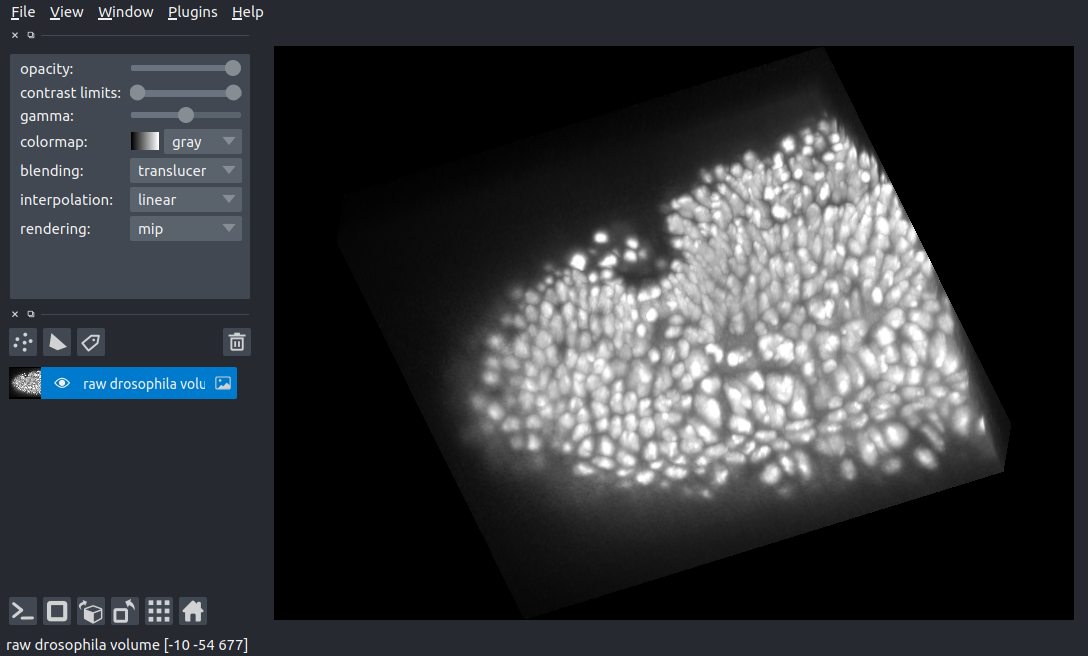

In [4]:
# note: display parameters were adjusted in the napari GUI before screenshot
nbscreenshot(v)

In [5]:
v.add_image(psf_droso, name="raw PSF")

<Image layer 'raw PSF' at 0x7fac87ce7c10>

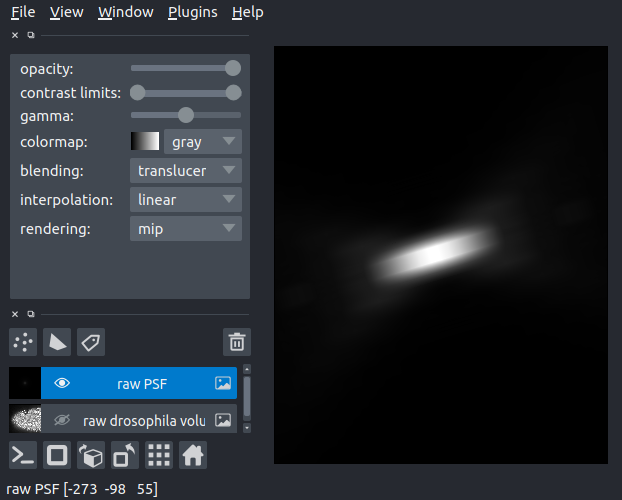

In [6]:
# note: display parameters were adjusted in the napari GUI before screenshot
nbscreenshot(v)

## Deconvolution on CPU using `numpy`

If we pass in numpy arrays, deconvolution happens using numpy on the CPU. This does not require dedicated hardware.

### Let's deconvolve with 5 iterations using Andrew-Biggs acceleration:

In [7]:
decon_np_accel_5 = richardson_lucy(vol_droso, psf_droso, iterations=5, accelerate=True)

In [8]:
v.add_image(decon_np_accel_5, name="np, 5 iter, acceleration")

<Image layer 'np, 5 iter, acceleration' at 0x7faca0ac2910>

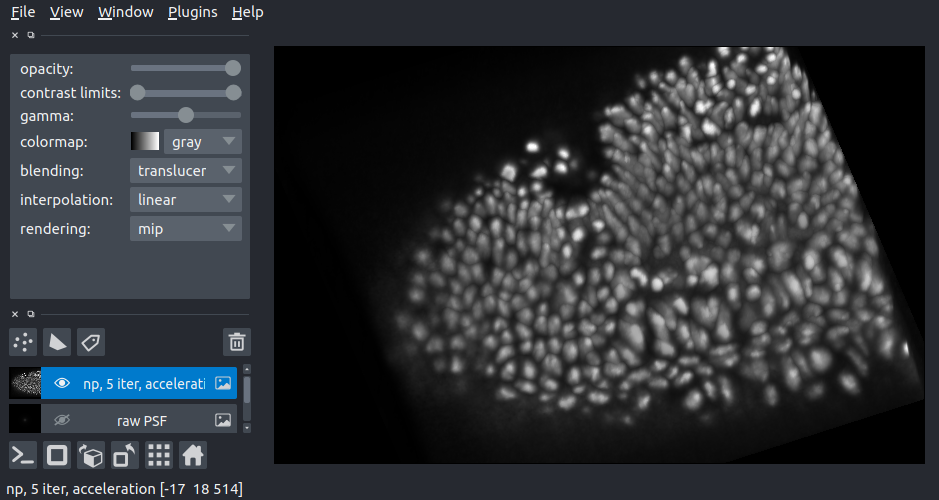

In [10]:
# note: display parameters were adjusted in the napari GUI before screenshot
nbscreenshot(v)

### Now without Andrew Biggs-Acceleration, using 10 iterations

Without Andrew-Biggs acceleration we need about twice as many iterations for a comparable result:

In [11]:
decon_np_10 = richardson_lucy(vol_droso, psf_droso, iterations=10, accelerate=False)

In [12]:
v.add_image(decon_np_accel_5, name="np, 10 iter, no acc.")

<Image layer 'np, 10 iter, no acc.' at 0x7fac9d41d0d0>

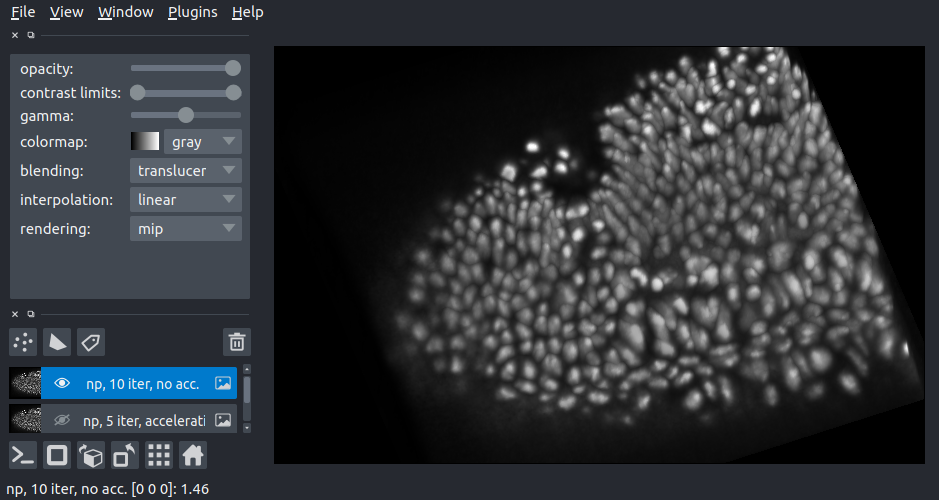

In [13]:
# note: display parameters were adjusted in the napari GUI before screenshot
nbscreenshot(v)

## Deconvolution on GPU using `cupy`

`Cupy` is a library that offers array computations on CUDA-GPUs with an API that follows `numpy` conventions. As `cupy` adheres to the NEP-18 dispatch mechanism we can use the existing code for deconvolution and get GPU acceleration without further changes if we 
pass in `cupy` arrays. 

Make sure to use `cupy` version `8.0` or later as it implements caching of FFT plans. As the FFT is called multiple times for each iteration, this provides additional speedup compared to earlier versions.

You will need a CUDA compatible GPU for the following:

In [14]:
import cupy as cp

cp.__version__

'8.0.0'

Create `cupy` arrays from the `numpy` arrays:

In [15]:
cp_vol_droso = cp.asarray(vol_droso)
cp_psf_droso = cp.asarray(psf_droso)

Now call the same functions as in the numpy examples above, but pass in the `cupy` arrays.

In [16]:
decon_cp_accel_5 = richardson_lucy(cp_vol_droso, cp_psf_droso, iterations=5, accelerate=True)
decon_cp_10 = richardson_lucy(cp_vol_droso, cp_psf_droso, iterations=10, accelerate=False)

This should have been much faster. The result will now be `cupy` arrays !

In [17]:
type(decon_cp_10), type(decon_cp_accel_5)

(cupy.core.core.ndarray, cupy.core.core.ndarray)

To visualize in napari, we first need to convert back to `numpy`. 
You can visually confirm that the results are similar:

In [18]:
v.add_image(cp.asnumpy(decon_cp_accel_5), name="cp, 5 iter, acceleration")
v.add_image(cp.asnumpy(decon_cp_10), name="cp, 10 iter, no acc.")

<Image layer 'cp, 10 iter, no acc.' at 0x7fac40170d90>

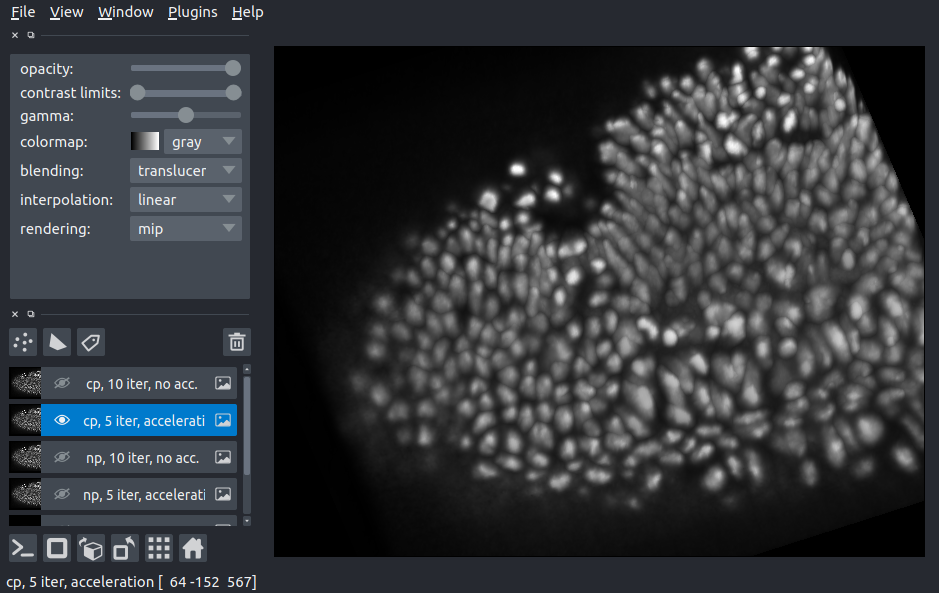

In [19]:
# note: display parameters were adjusted in the napari GUI before screenshot
nbscreenshot(v)

## Are the results identical ?

We don't expect the GPU and CPU based results to be exactly identical due to different precision.
We can find out the numerical precision for the dtype:

In [20]:
eps = np.finfo(decon_np_10.dtype).eps
eps

2.220446049250313e-16

However, not all pixels are identical within this precision between GPU and CPU (on my machine):


In [21]:
np.all((cp.asnumpy(decon_cp_10) - decon_np_10) < eps)

False

This is not completely unexpected, as small numerical imprecisions will compound over multiple iterations.
Let's check whether the results agree with a slightly relaxed precision requirement:

In [22]:
np.all((cp.asnumpy(decon_cp_10) - decon_np_10) < 10**-10)

True

# Timing 


Let's look at how fast this is.
These benchmarks were taken on a workstation with a
* CPU: Ryzen 5 3500X 
* GPU: Nvidia RTX 2060 

As we just want to benchmark the RL iterations and not the preparation of the PSF and OTF,
we use `_richardson_lucy(...)` instead of `richardson_lucy(...)`.

### Numpy

In [23]:
# prepare OTF
vol, psf, otf = _prep(vol_droso, psf_droso / psf_droso.sum())

In [24]:
%timeit result = _richardson_lucy(vol, psf, otf, 10, True)

3.39 s ± 56.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
# same number of iterations, no Andrew-Biggs
%timeit result= _richardson_lucy(vol, psf, otf, 10, False)

3.13 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
# now with more iterations
%timeit result = _richardson_lucy(vol, psf, otf, 100, True)

33.4 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cupy
same timings with cupy arrays

In [27]:
cp_vol, cp_psf, cp_otf = _prep(cp.asarray(vol_droso), cp.asarray(psf_droso / psf_droso.sum()))

In [28]:
%timeit result = _richardson_lucy(cp_vol, cp_psf, cp_otf, 10, True)

241 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
# same number of iterations, no Andrew-Biggs
%timeit result= _richardson_lucy(cp_vol, cp_psf, cp_otf, 10, False)

181 ms ± 70.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
# again, with more iterations
%timeit result = _richardson_lucy(cp_vol, cp_psf, cp_otf, 100, True)

2.45 s ± 48.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Unsurprisingly, working on `cupy` arrays on the GPU is substantially faster.